# Import the libraries

In [11]:
# !pip install catboost

In [12]:
! pip install imbalanced-learn

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import LabelEncoder,  StandardScaler,OrdinalEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler

# Load The Dataset

In [14]:
train_df = pd.read_csv(r"D:\Winter_Arc_Projects\Predicting-Loan-Payback\NoteBooks\data\train.csv")

In [15]:
train_df.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## About Dataset
#### 1. Borrower’s Demographics 

> age (int64) – Borrower's age (in years).

> gender (category) – Borrower's gender (Male/Female).

> marital_status (category) – Marital status (Single, Married, Divorced).

> education_level (category) – Education level (High School, Bachelor, Master, PhD).

#### 2. Financial Information

> annual_income (float64) – Borrower's yearly income.

> monthly_income (float64) – Borrower's monthly income.

> employment_status (category) – Current employment type (Employed, Self-Employed, Unemployed).

> debt_to_income_ratio (float64) – Ratio of borrower’s debt to their income. Lower = better.

> credit_score (int64) – Credit bureau score (e.g., FICO). Higher = less risky.

#### 3. Loan Information

> loan_amount (float64) – Amount of loan taken.

> loan_purpose (category) – Loan purpose (Car, Education, Home, Medical, etc.).

> interest_rate (float64) – Loan par annual interest rate (%).

> loan_term (int64) – Loan repayment duration (months, e.g., 36 or 60).

> installment (float64) – Monthly installment .

> grade_subgrade (category) – Risk category assigned to loan (A1, B2, etc.).

#### 4. Borrower’s Credit History

> num_of_open_accounts (int64) – Total active credit accounts.

> total_credit_limit (float64) – Borrower's total available credit limit.

> current_balance (float64) – Borrower's outstanding balance (loan + credit card).

> delinquency_history (int64) – Count of late payments in borrower’s history.

> public_records (int64) – Negative public records (e.g., bankruptcies, legal actions).

> num_of_delinquencies (int64) – Total delinquencies (missed payments).

#### 5. Target Variable

> loan_paid_back (int64) – Target variable:

> 1 → Borrower paid loan in full.

> 0 → Borrower defaulted (did not repay fully). 

In [16]:
from colorama import Fore, Style

# Print the shape of the dataframe (number of rows and columns)
print(Fore.CYAN + "train_df shape: " + Style.RESET_ALL)
print(f"{train_df.shape}\n")

# Print basic information about the dataframe (column names, data types, non-null values)
print(Fore.GREEN + "train_df info: " + Style.RESET_ALL)
print(f"{train_df.info()}\n")

# Print the count of missing (NaN) values in each column
print(Fore.YELLOW + "train_df isnull sum: " + Style.RESET_ALL)
print(f"{train_df.isnull().sum()}\n")

# Print summary statistics for numerical columns (count, mean, std, min, max, etc.)
print(Fore.MAGENTA + "train_df describe: " + Style.RESET_ALL)
print(f"{train_df.describe()}\n")


train_df shape: 
(593994, 13)

train_df info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB

In [17]:
# Define the numerical & categorical
numerical_col = train_df.select_dtypes(include = ["int64","float64"]).columns
# Define the categorical
categorical_col = train_df.select_dtypes(include = "object").columns

print(f"We have features: {len(numerical_col)} numerical features {numerical_col}")
print("-"*100)
print(f"We have features: {len(categorical_col)} categorical features {categorical_col}")

We have features: 7 numerical features Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'loan_paid_back'],
      dtype='object')
----------------------------------------------------------------------------------------------------
We have features: 6 categorical features Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')


# Exploratory Data Analysis (EDA)

--- Visualizing: annual_income ---


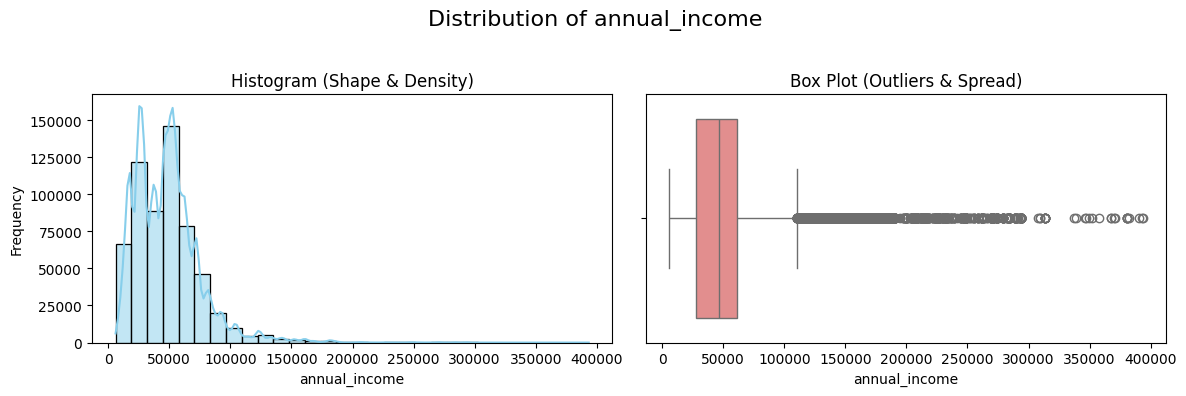


📊 Descriptive Statistics:
count    593994.000
mean      48212.203
std       26711.942
min        6002.430
25%       27934.400
50%       46557.680
75%       60981.320
max      393381.740
Name: annual_income, dtype: float64


--- Visualizing: debt_to_income_ratio ---


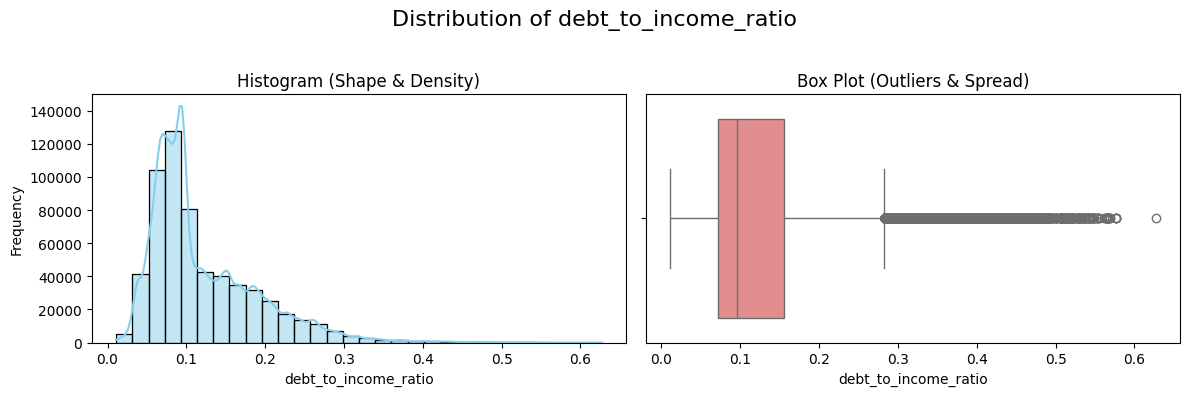


📊 Descriptive Statistics:
count    593994.000
mean          0.121
std           0.069
min           0.011
25%           0.072
50%           0.096
75%           0.156
max           0.627
Name: debt_to_income_ratio, dtype: float64


--- Visualizing: credit_score ---


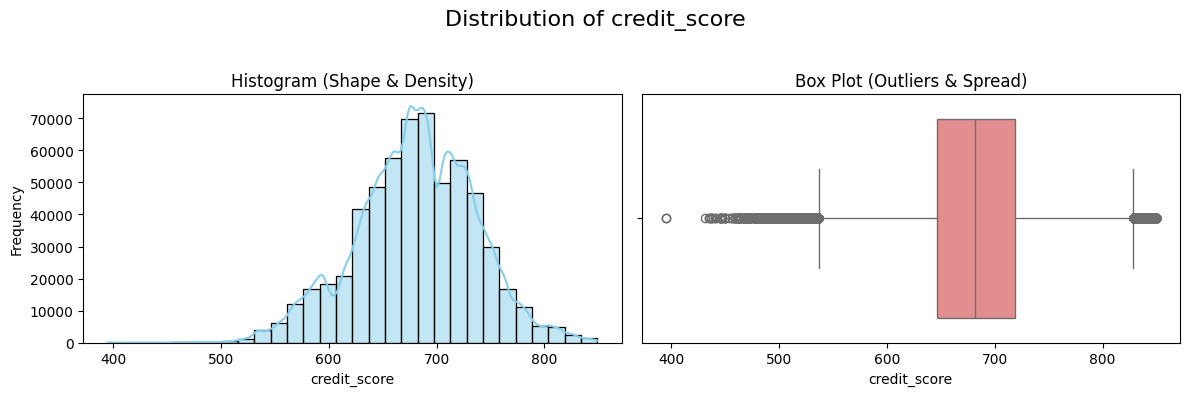


📊 Descriptive Statistics:
count    593994.000
mean        680.916
std          55.425
min         395.000
25%         646.000
50%         682.000
75%         719.000
max         849.000
Name: credit_score, dtype: float64


--- Visualizing: loan_amount ---


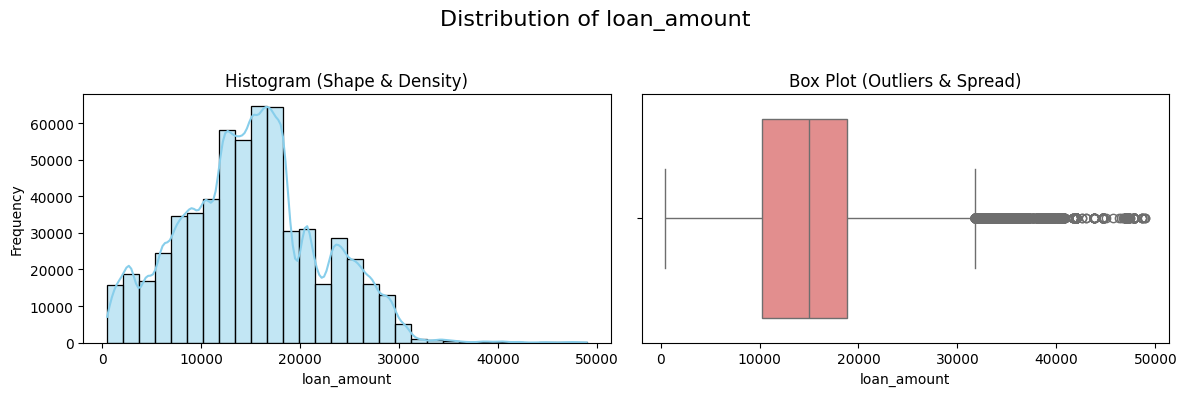


📊 Descriptive Statistics:
count    593994.000
mean      15020.298
std        6926.531
min         500.090
25%       10279.620
50%       15000.220
75%       18858.580
max       48959.950
Name: loan_amount, dtype: float64


--- Visualizing: interest_rate ---


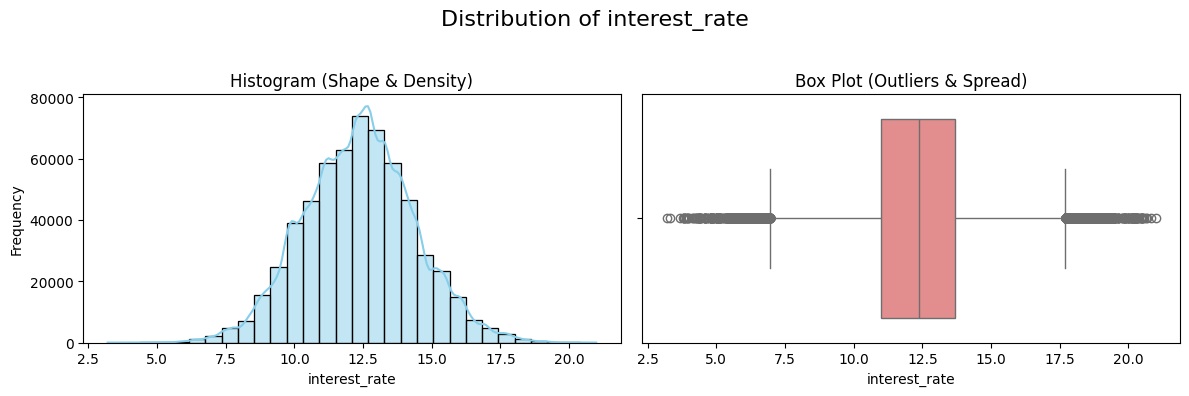


📊 Descriptive Statistics:
count    593994.000
mean         12.356
std           2.009
min           3.200
25%          10.990
50%          12.370
75%          13.680
max          20.990
Name: interest_rate, dtype: float64




In [18]:
# -------------------------------------------------------
# 🎯 Feature Distribution Visualization (Numerical Features)
# Target: loan_paid_back (Categorical)
# -------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns based on your dataset
numerical_cols = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

# Separate the columns based on their nature
continuous_features = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

# (If you later add any discrete numeric features, like num_of_loans, put them here)
discrete_features = []

# Loop through each numerical column
for col in numerical_cols:
    print(f"--- Visualizing: {col} ---")

    # Set up a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Distribution of {col}', fontsize=16)

    if col in continuous_features:
        # Left: Histogram for density/shape
        sns.histplot(train_df[col].dropna(), kde=True, bins=30,
                     ax=axes[0], color='skyblue', edgecolor='black')
        axes[0].set_title('Histogram (Shape & Density)')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Right: Boxplot for quartiles/outliers
        sns.boxplot(x=train_df[col].dropna(), ax=axes[1], color='lightcoral')
        axes[1].set_title('Box Plot (Outliers & Spread)')
        axes[1].set_xlabel(col)

    elif col in discrete_features:
        # Left: Count Plot for small integer-like features
        sns.countplot(x=train_df[col].dropna(), ax=axes[0], palette='viridis', edgecolor='black')
        axes[0].set_title('Count Plot (Frequency)')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')

        # Right: Boxplot (still useful)
        sns.boxplot(x=train_df[col].dropna(), ax=axes[1], color='lightcoral')
        axes[1].set_title('Box Plot (Summary)')
        axes[1].set_xlabel(col)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print descriptive statistics
    print("\n📊 Descriptive Statistics:")
    print(train_df[col].describe().round(3))
    print("\n" + "="*50 + "\n")

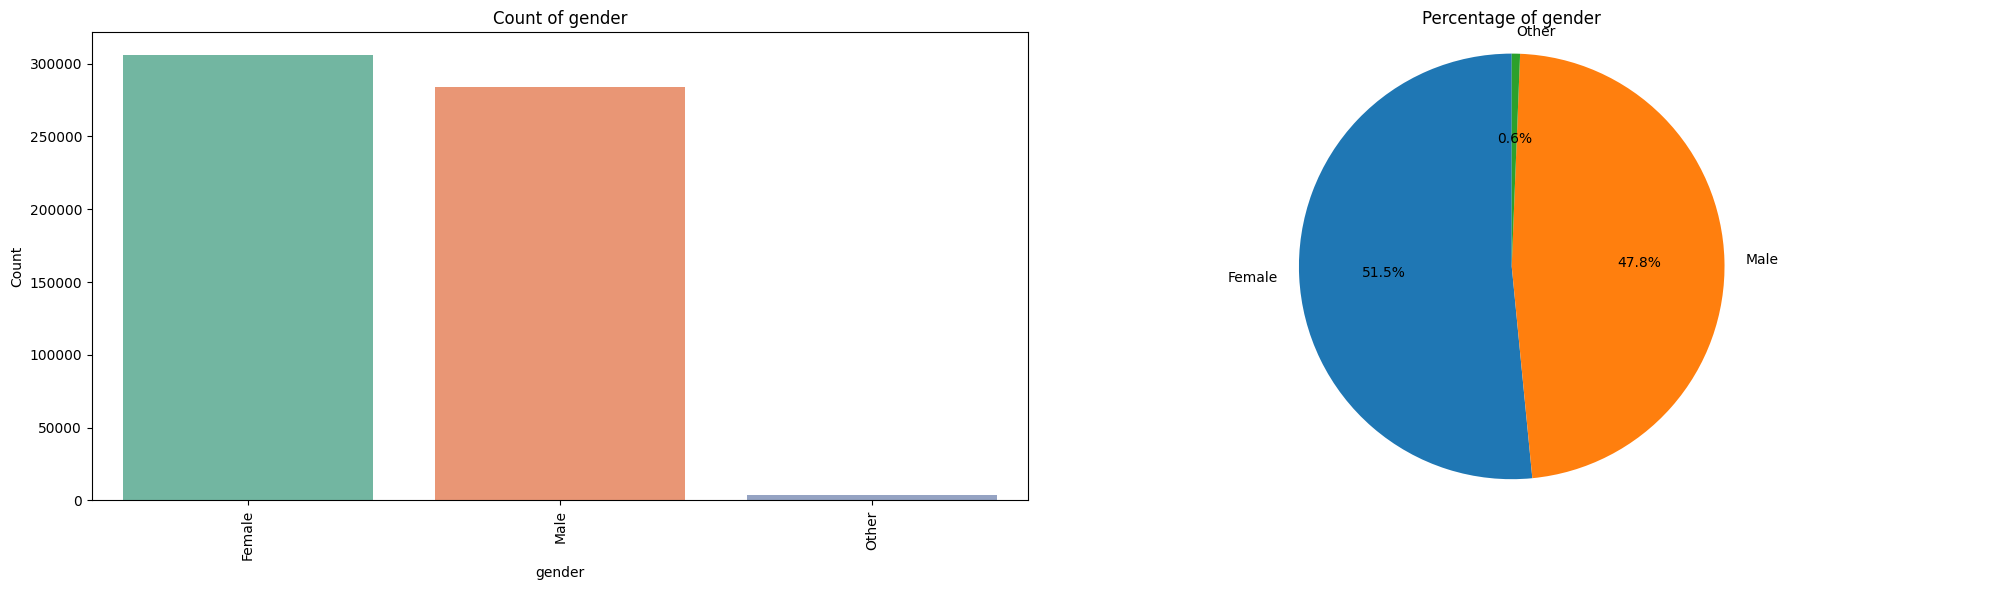

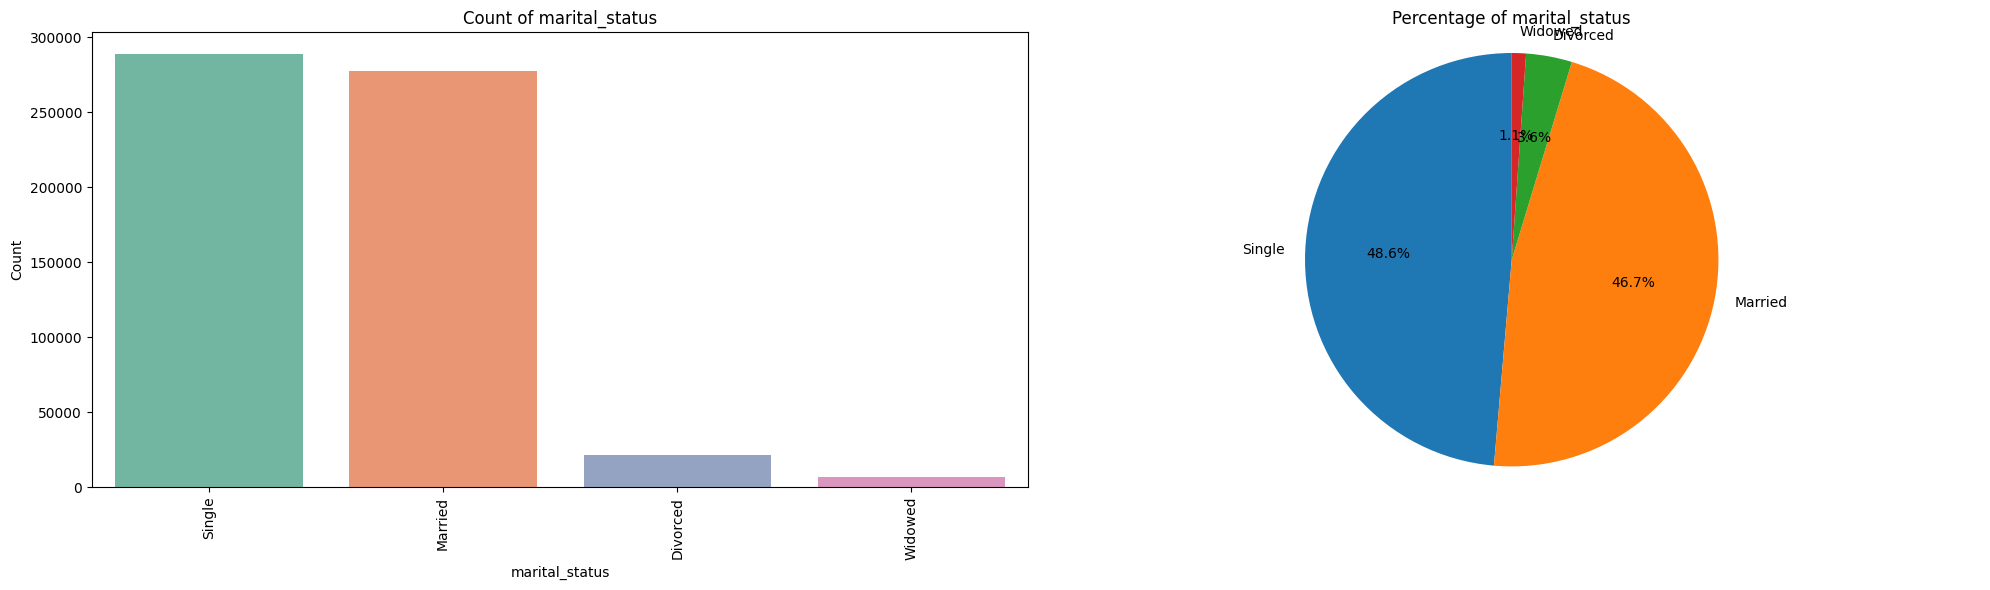

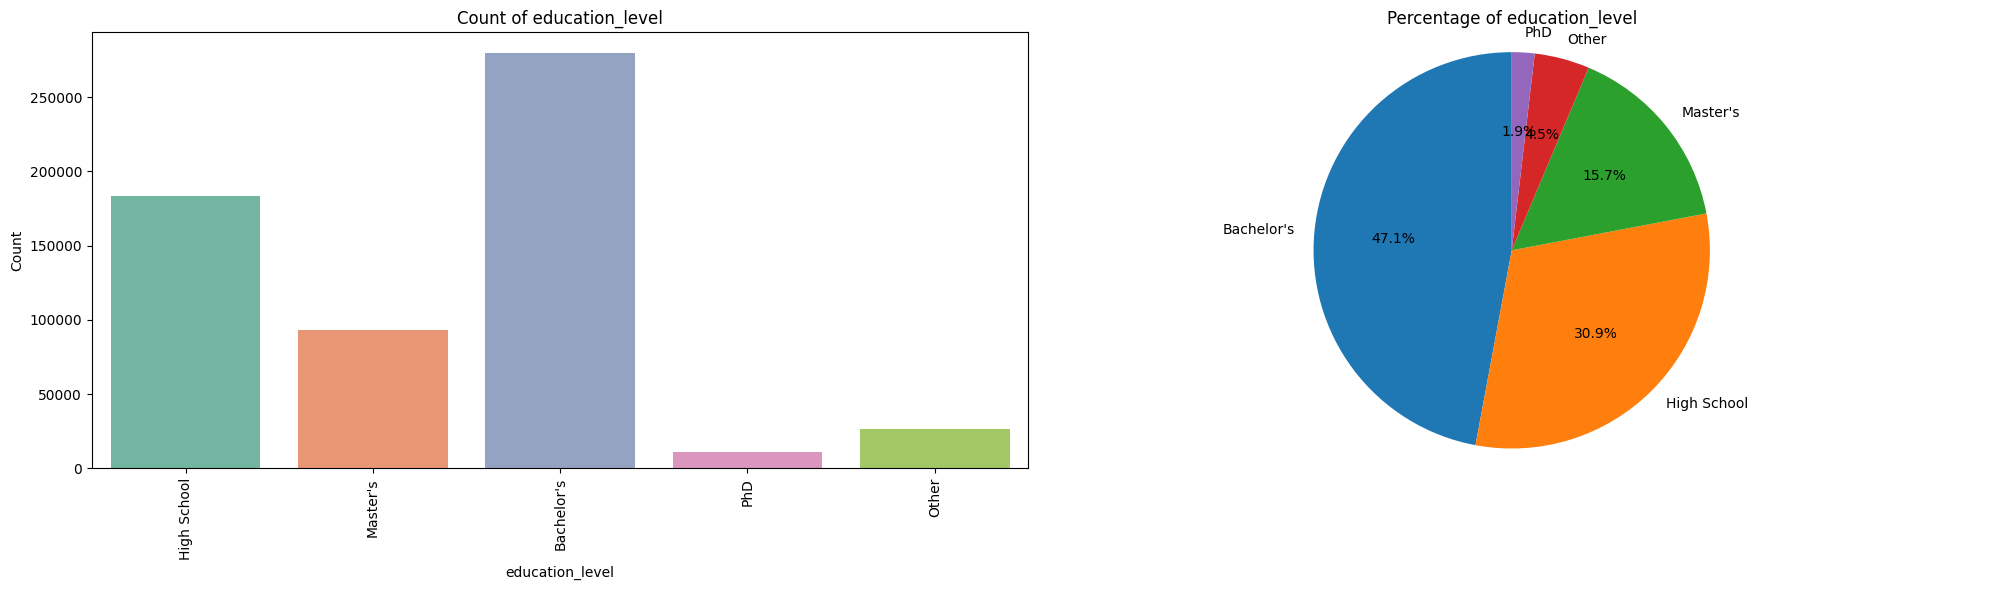

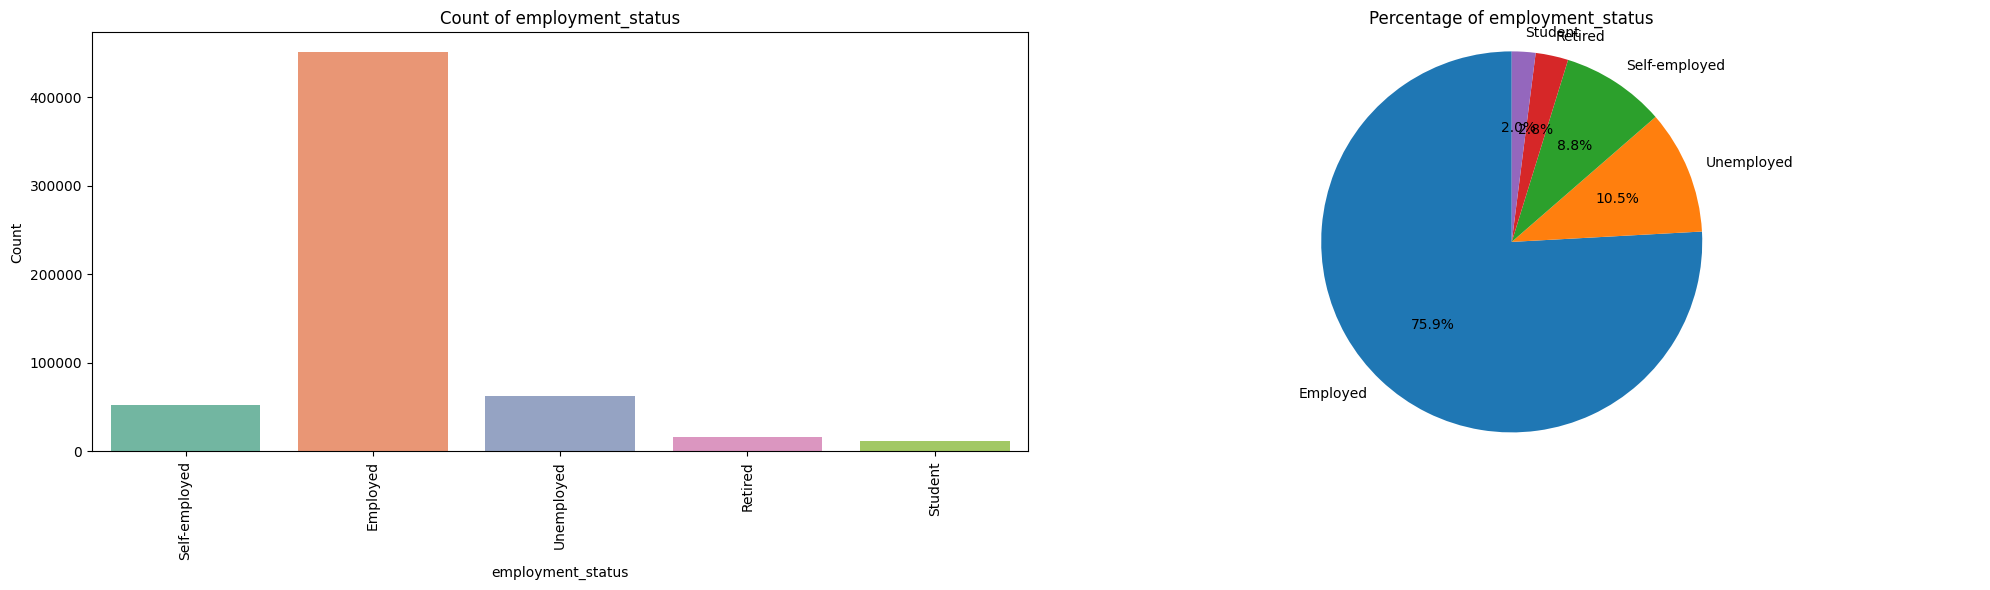

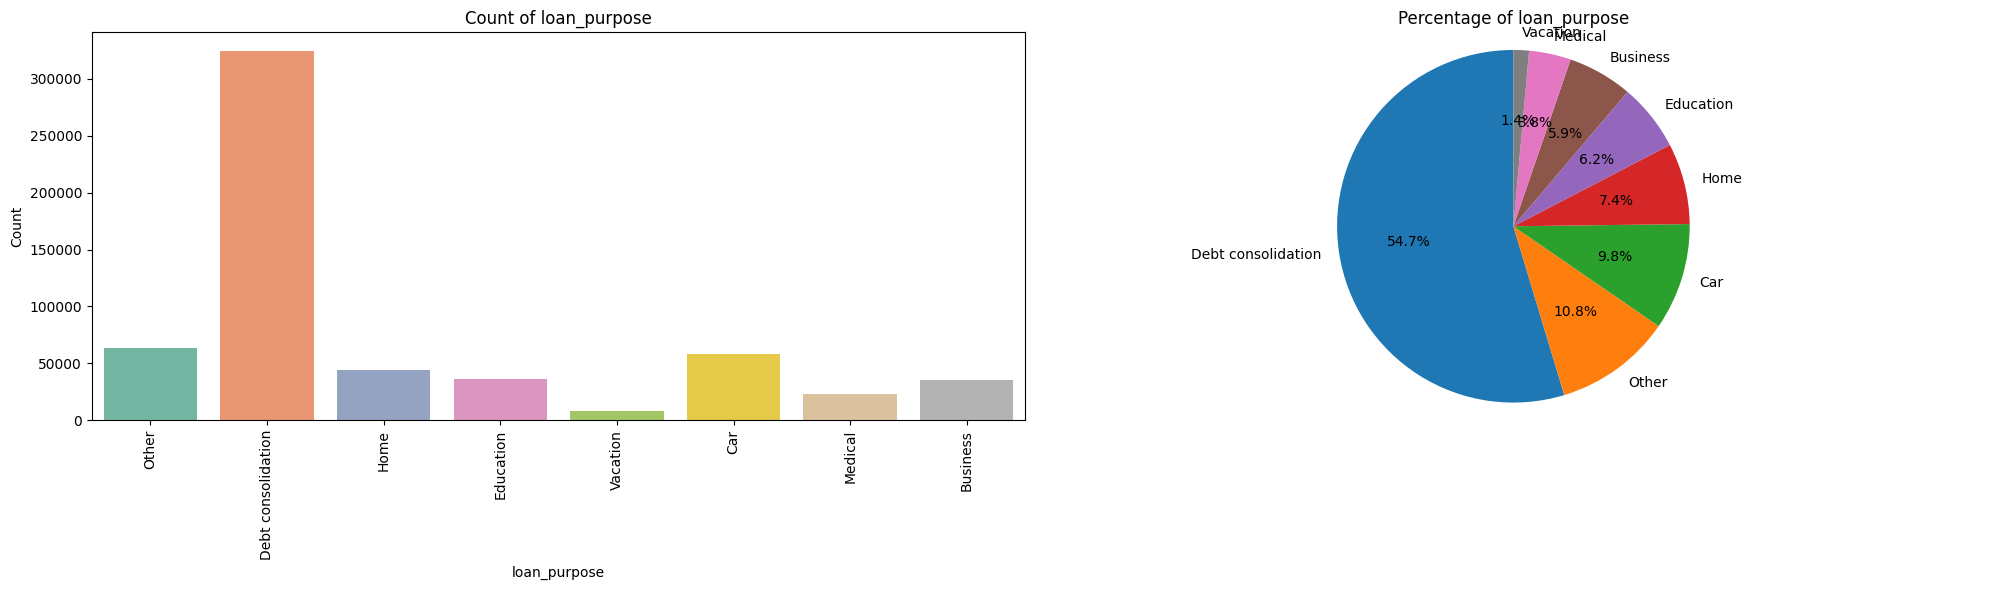

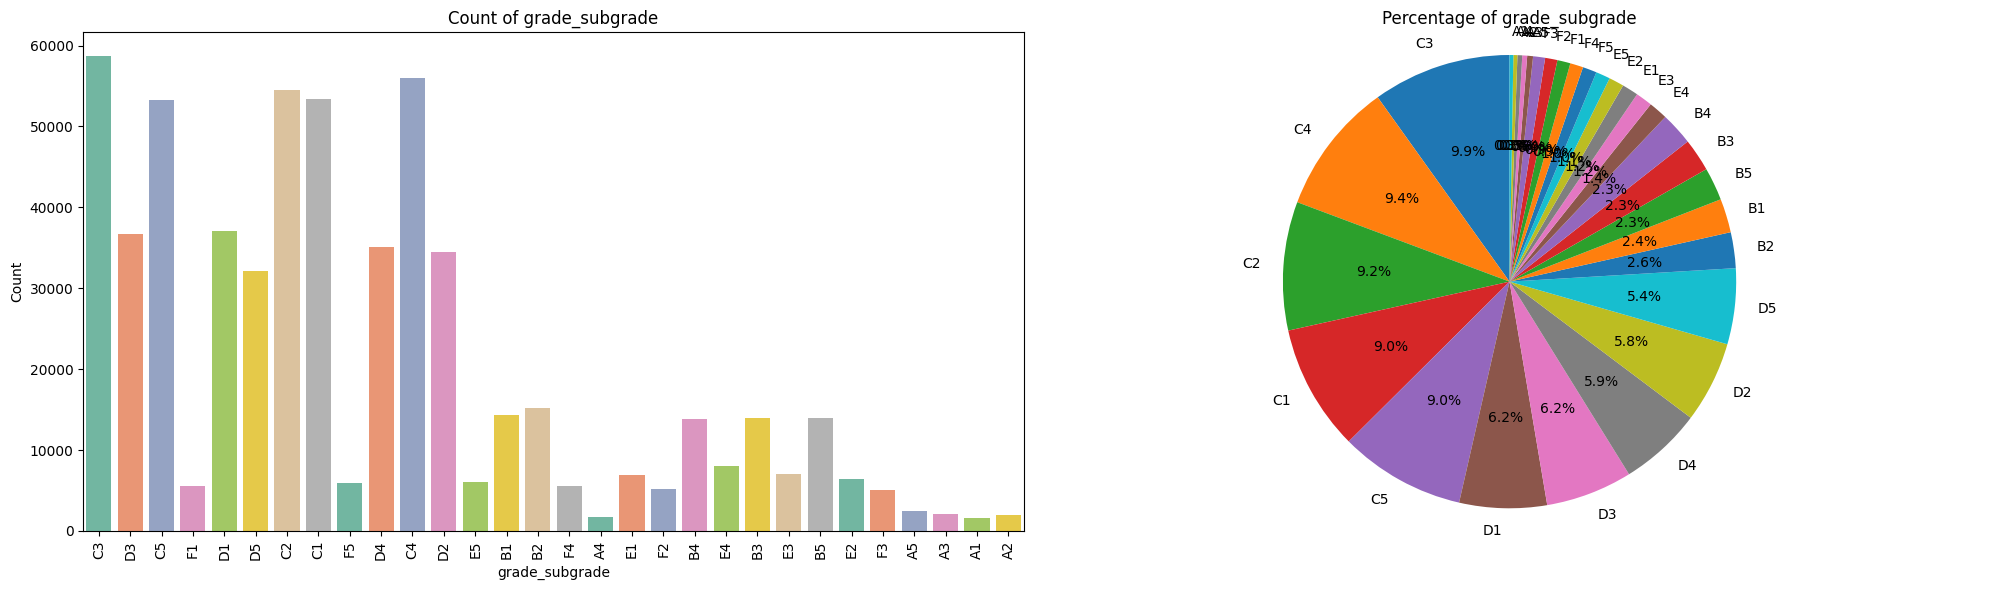

In [19]:
# 📊 Distribution of Categorical Features

for col in categorical_col:
    counts = train_df[col].value_counts()
    plt.figure(figsize = (20,6))
    plt.subplot(1,2,1)
    sns.countplot(data = train_df, x = col,  palette = "Set2")
    plt.title(f"Count of {col}")
    plt.xticks(rotation = 90)
    plt.ylabel("Count")

    plt.subplot(1,2,2)
    plt.pie(counts,labels = counts.index,autopct = "%1.1f%%",startangle=90)
    plt.title(f"Percentage of {col}")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

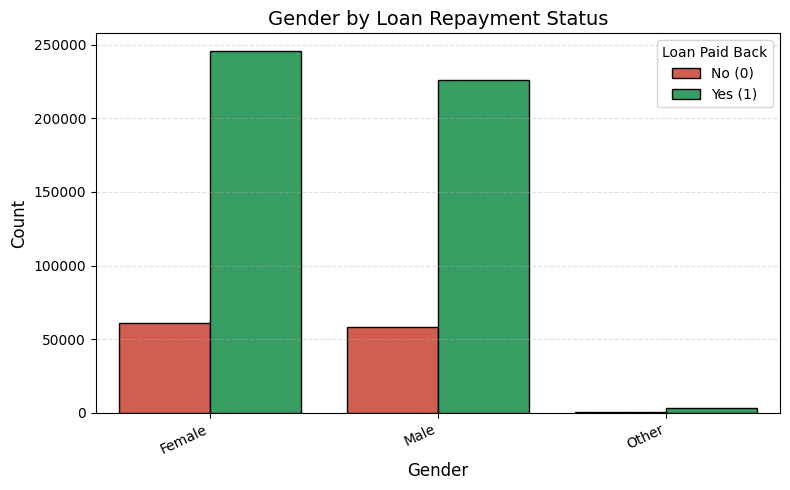

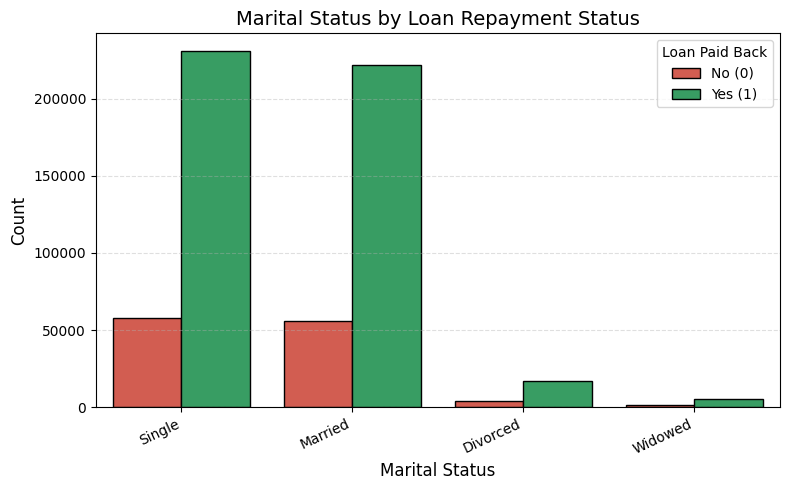

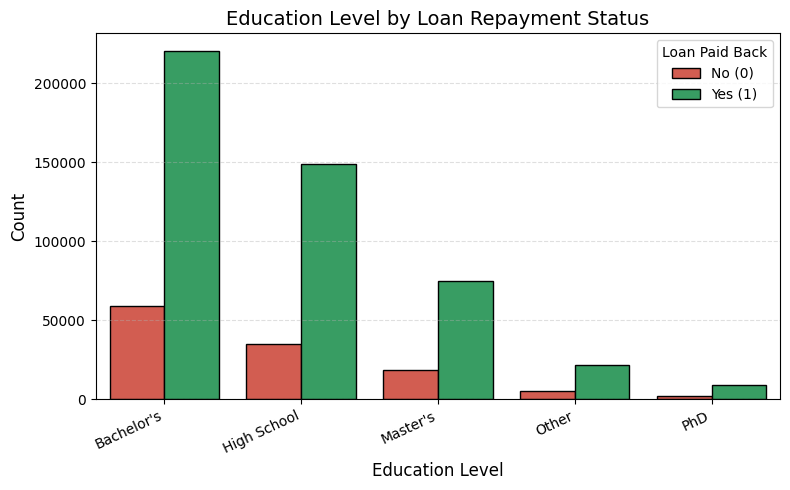

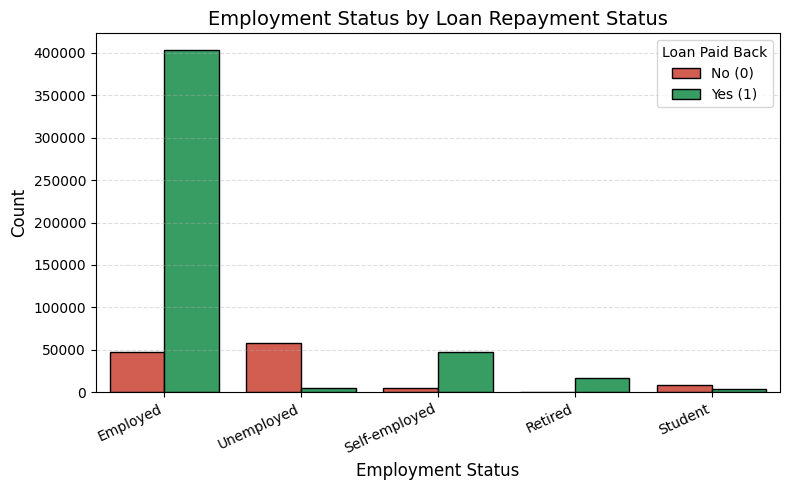

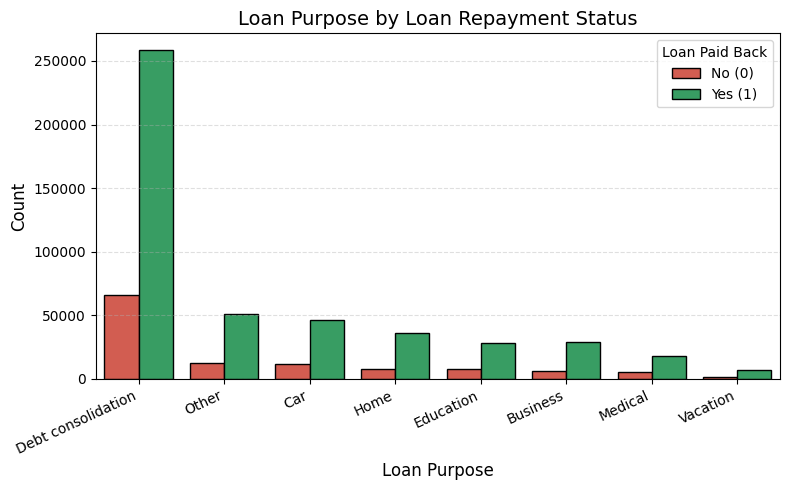

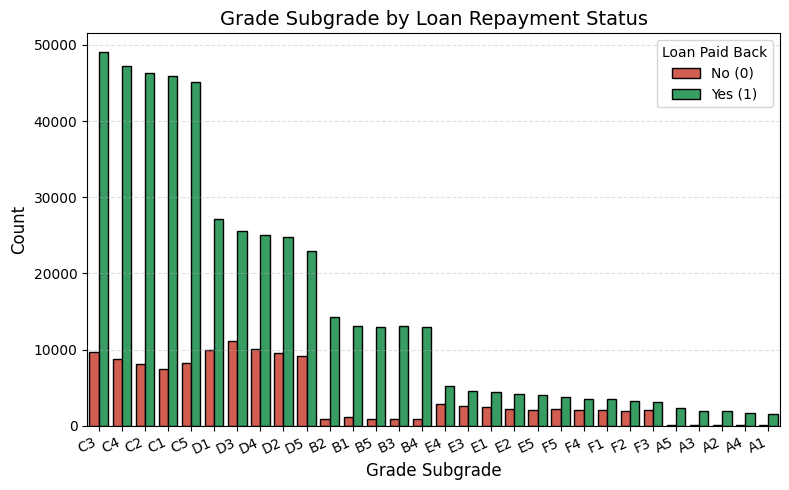

In [20]:
# 🎨 Categorical Feature Distributions by Loan Repayment Status - Custom Colors

# Select key categorical columns to explore their relationship with the target
cols_to_plot = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

# Custom colors: green for Paid (1), red for Not Paid (0)
custom_palette = ['#E74C3C', '#27AE60']  # Red = Not Paid, Green = Paid

target_col = 'loan_paid_back'  # Binary target variable (0 or 1)

for col in cols_to_plot:
    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=train_df,
        x=col,
        hue=target_col,
        palette=custom_palette,
        edgecolor='black',
        order=train_df[col].value_counts().index  # Order bars by frequency
    )

    plt.title(f'{col.replace("_", " ").title()} by Loan Repayment Status', fontsize=14)
    plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=25, ha='right')

    # Legend reflecting your target variable meaning
    plt.legend(title='Loan Paid Back', labels=['No (0)', 'Yes (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [21]:
from scipy.stats import chi2_contingency
chi2_test = []
for feature in categorical_col:
    if chi2_contingency(pd.crosstab(train_df['loan_paid_back'], train_df[feature]))[1] < 0.05:
        chi2_test.append('Reject Null Hypothesis')
    else:
        chi2_test.append('Fail to Reject Null Hypothesis')
result = pd.DataFrame(data=[categorical_col, chi2_test]).T # Create a DataFrame to store the chi-squared test results
result.columns = ['Column', 'Hypothesis Result']
result

,Column,Hypothesis Result
0,gender,Reject Null Hypothesis
1,marital_status,Fail to Reject Null Hypothesis
2,education_level,Reject Null Hypothesis
3,employment_status,Reject Null Hypothesis
4,loan_purpose,Reject Null Hypothesis
5,grade_subgrade,Reject Null Hypothesis


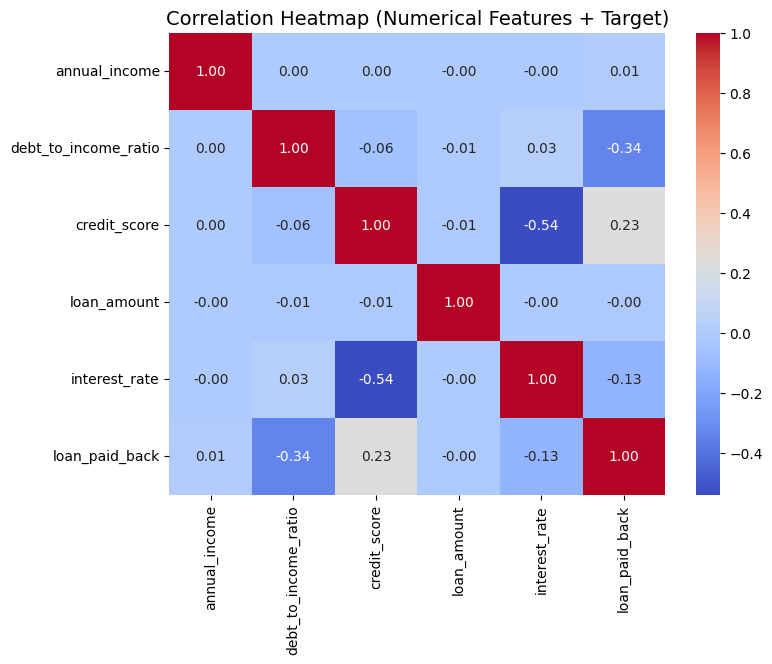

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[['annual_income', 'debt_to_income_ratio', 'credit_score',
                'loan_amount', 'interest_rate', 'loan_paid_back']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numerical Features + Target)', fontsize=14)
plt.show()

# Preprocessing

In [23]:
num_cols = train_df[["annual_income","debt_to_income_ratio","credit_score","loan_amount","interest_rate"]]

In [24]:
from scipy.stats import skew

skew_values = num_cols.apply(lambda x: skew(x.dropna()))
print(skew_values.sort_values(ascending=False))

annual_income           1.719504
debt_to_income_ratio    1.406676
loan_amount             0.207359
interest_rate           0.049945
credit_score           -0.166992
dtype: float64


In [25]:
skewed_cols = skew_values[abs(skew_values) > 1].index.tolist()
print("Highly skewed columns:", skewed_cols)

for col in skewed_cols:
    train_df[col] = np.log1p(train_df[col])

from sklearn.preprocessing import PowerTransformer

# Initialize Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

Highly skewed columns: ['annual_income', 'debt_to_income_ratio']


# Outliers (IQR)

In [26]:
for col in num_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_df[col] = train_df[col].clip(lower=lower_bound, upper=upper_bound)

**Our target column is inblanced**

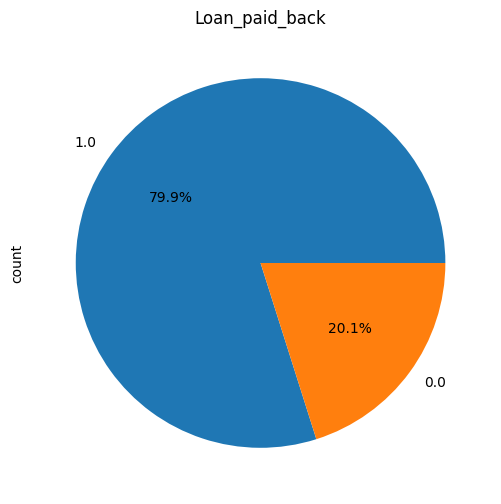

In [27]:
train_df["loan_paid_back"].value_counts().plot(kind = "pie", autopct='%1.1f%%',figsize=(6, 6),title = "Loan_paid_back")
plt.show()


# Feature Engineering

In [28]:
def create_features(df):

    df = df.copy()

    df['income_to_loan_ratio'] = df['annual_income'] / df['loan_amount']
    df['affordability_ratio'] = (df['annual_income'] / 12) / (df['loan_amount'] * df['interest_rate'] / 1200)

    df['risk_score'] = (
        df['debt_to_income_ratio'] * 0.3 +
        (800 - df['credit_score']) / 800 * 0.3 +
        df['interest_rate'] / 25 * 0.2 +
        (df['loan_amount'] / df['annual_income']) * 0.2
    )

    if 'grade_subgrade' in df.columns:
        df['grade'] = df['grade_subgrade'].str[0]
        df['subgrade_num'] = df['grade_subgrade'].str[1].astype(int)


    employment_mapping = {
        'Unemployed': 0,
        'Student': 1,
        'Self-employed': 2,
        'Employed': 3,
        'Retired': 2
    }
    df['employment_stability'] = df['employment_status'].map(employment_mapping)

    education_mapping = {
        'High School': 1,
        'Other': 2,
        'Bachelor\'s': 3,
        'Master\'s': 4,
        'PhD': 5
    }
    df['education_num'] = df['education_level'].map(education_mapping)

    return df

# Applying Feature engineering
# Applying Feature engineering
train_df_eng = create_features(train_df)

In [29]:
def preprocess_data(train_df):
    # make copies so original dfs are not modified unexpectedly
    train_df = train_df.copy()
    # drop columns properly..
    cols_to_drop = ["education_level", "employment_status","grade_subgrade"]
    cols_to_drop = [c for c in cols_to_drop if c in train_df.columns]
    if cols_to_drop:
        train_df = train_df.drop(columns=cols_to_drop)
    
        # Numerical features
    features = [
        'id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
        'loan_amount', 'interest_rate', 'loan_paid_back',
        'income_to_loan_ratio', 'affordability_ratio', 'risk_score',
        'subgrade_num', 'employment_stability', 'education_num'
    ]
    # categorical features
    categorical_cols = ['gender', 'marital_status', 'loan_purpose', 'grade']

    # Keep only categorical columns that actually exist
    categorical_cols = [c for c in categorical_cols if c in train_df.columns]

    #  Encode categorical columns robustly ---
    if categorical_cols:
        enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        # fit on train's categorical columns
        enc.fit(train_df[categorical_cols])
        # transform both train and test (returns numpy array; assign back)
        train_df[categorical_cols] = enc.transform(train_df[categorical_cols])
    
    return train_df


    

In [30]:
train_processed = preprocess_data(train_df_eng)
print(train_processed.shape)

(593994, 17)


In [31]:
# Train Test split
X = train_processed.drop(columns=["loan_paid_back"])
y = train_processed["loan_paid_back"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# StandarScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [32]:

# Models dicts
models = {
    "LightGBM": LGBMClassifier(
        objective='binary',
        metric = "auc",
        boosting_type = "gbdt",
        n_estimators = 1000,
        learning_rate = 0.01,
        colsample_freq = 1,
        min_child_samples = 20,
        reg_alpha = 0.05,
        reg_lambda=0.1,
        random_state = 42,
        n_jobs = -1,
        device = "cpu",
        verbose = -1
    ),
    "CatBoost": CatBoostClassifier(
        iterations = 3000,
        learning_rate = 0.03,
        depth = 8,
        loss_function = "Logloss",
        eval_metric = "AUC",
        random_state = 42,
        # verbosity= 0
        auto_class_weights = "Balanced",
        l2_leaf_reg=5,
        task_type="CPU"
    ),
    "XGBoost" : XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "auc",
        learning_rate = 0.01,
        max_depth = 8,
        min_child_weight = 3,
        colsample_bytree = 0.3,
        subsample = 0.6,
        reg_alpha = 0.5,
        reg_lambda = 2.0,
        n_estimators = 10000,
        random_state = 42,
        n_jobs = -1,
        verbose = -1,
        device = 'cpu',
        tree_method = 'hist'
    )
}

In [33]:
def off_predictions(model,X,y,X_test,n_splits):
  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

  off_train = np.zeros(len(X))
  off_test = np.zeros(len(X_test))

  for fold, (tr_idx, val_idx) in enumerate(skf.split(X,y)):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model.fit(X_tr, y_tr)

    off_train[val_idx] = model.predict_proba(X_val)[:,1]
    off_test += model.predict_proba(X_test)[:,1] / n_splits

    fold_auc = roc_auc_score(y_val, off_train[val_idx])
    print(f"Fold {fold+1} AUC: {fold_auc:.5f}")

  total_auc = roc_auc_score(y, off_train)
  print(f"\n OOF AUC: {total_auc:.5f}")

  return off_train, off_test


In [ ]:
oof_cat, test_cat = off_predictions(
    models["CatBoost"], X, y, X_test, n_splits=5
)

oof_lgb, test_lgb = off_predictions(
    models["LightGBM"], X, y, X_test, n_splits=5
)

oof_xgb, test_xgb = off_predictions(
    models["XGBoost"], X, y, X_test, n_splits=5
)

In [ ]:
blend_oof = (
    0.4 * oof_cat +
    0.3 * oof_lgb +
    0.3 * oof_xgb
)

blend_test = (
    0.4 * test_cat +
    0.3 * test_lgb +
    0.3 * test_xgb
)

print("Blended OOF AUC:", roc_auc_score(y, blend_oof))

Blended OOF AUC: 0.920237451891716
